# Experimentation notebook

In [737]:
import sys
import torch
sys.path.append('src/fast_ica')
sys.path.append('src/iVAE')

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 5

from tqdm import tqdm
from sklearn.decomposition import FastICA as skFastICA
from torch.utils.data import DataLoader
from torch.optim import Adam, lr_scheduler

from src.iVAE.models import cleanIVAE, cleanVAE
from src.iVAE.data import CustomSyntheticDataset, SyntheticDataset, generate_data
from src.iVAE.metrics import mean_corr_coef as mcc
from src.fast_ica import FastICA

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using cpu device


In [738]:
def train(
    my_model, 
    my_optimizer,
    my_scheduler,
    my_data_loader,
    eval_mixture,
    eval_sources, 
    eval_conditioning, 
    epochs, 
    device, 
    **elbo_kwargs
):
    """_summary_

    Args:
        my_model (_type_): _description_
        my_optimizer (_type_): _description_
        my_data_loader (_type_): _description_
        eval_mixture (_type_): _description_
        eval_sources (_type_): _description_
        epochs (_type_): _description_

    Returns:
        _type_: _description_
    """

    train_loss_hist = []
    train_perf_hist = []
    eval_perf_hist = []

    eval_mixture, eval_sources = eval_mixture.to(device), eval_sources.to(device)
    itterable = tqdm(range(1, epochs+1))
    for epoch in itterable:
        # Train
        my_model.train()
        train_loss = 0
        train_perf = 0
        for _, data in enumerate(my_data_loader):
            x, u, s_true = data
            x, u = x.to(device), u.to(device)
            my_optimizer.zero_grad()
            loss, s_predicted = my_model.elbo(x, u, **elbo_kwargs)
            loss.backward()
            train_loss += loss.item()
            try:
                perf = mcc(s_true.numpy(), s_predicted.cpu().detach().numpy())
            except:
                perf = 0
            train_perf += perf
            my_optimizer.step()

        train_perf /= len(my_data_loader)
        train_perf_hist.append(train_perf)
        train_loss /= len(my_data_loader)
        train_loss_hist.append(train_loss)

        # Evaluate
        my_model.eval()
        _, _, _, s, _ = my_model(eval_mixture, eval_conditioning)
        try:
            eval_perf = mcc(eval_sources.numpy(), s.cpu().detach().numpy())
        except:
            eval_perf = 0
        eval_perf_hist.append(eval_perf)

        itterable.set_description(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.2f} | Train Perf: {train_perf:.2f} | Eval Perf: {eval_perf:.2f}")

        my_scheduler.step(train_loss)

    return train_loss_hist, train_perf_hist, eval_perf_hist


## Parameters

In [739]:
number_of_points_by_segment = 500
number_of_segments = 5
dimension_of_latent_space = 2
dimension_of_data_space = 2
seed = 1
prior = 'gauss'

simple_mixing = False 
linear_transformation_type="uniform"
activation = 'xtanh' # if simple_mixing is True, activation is not used
slope = 0.1 # if simple_mixing is True, slope is not used
number_of_mixing_layers = 10 # if simple_mixing is True, number_of_mixing_layers is not used
repeat_linearity = False # if simple_mixing is True, repeat_linearity is not used

uncentered = True
# centers = np.random.uniform(-15, 15, (number_of_segments, dimension_of_data_space))
centers = np.array([[-5,6], [0,0], [0,-4], [1,2], [6,0 ]])

var_bounds = np.array([0.5, 3])

noisy = 0.01
staircase = False

In [740]:
number_of_simulation = 1
vae_hidden_dim = 100
vae_n_layers = 3
vae_activation = 'lrelu'
vae_slope = 0.1

# Learning rate scheduler params
lr = 0.01
factor = 0.1
patience = 0
verbose = True

epochs = 50

# ELBO weights
a = 100 # reconstruction log-likelihood term
b = 1 #  KL divergence between the approximate posterior an implicit mixture distribution
c = 0 # difference between the log probabilities under the implicit mixture distribution and an importance-sampled approximation
d = 10 # KL divergence between the importance-sampled approximation of the log probabilities under the variational posterior and the prior

## Data

### Generation

In [741]:
dataset = SyntheticDataset(
    "./", 
    number_of_points_by_segment, 
    number_of_segments, 
    dimension_of_latent_space, 
    dimension_of_data_space, 
    number_of_mixing_layers, 
    seed, 
    prior,
    activation, 
    uncentered, 
    noisy, 
    one_hot_labels=True, 
    simple_mixing=simple_mixing,
    centers=centers,
)
source, mixture, segment_labels = dataset.s, dataset.x, dataset.u
indices = np.argmax(segment_labels, axis=1)

Creating dataset ./tcl_500_5_2_2_10_1_gauss_xtanh_u_noisy_one_hot.npz ...
 ... done
loading data from ./tcl_500_5_2_2_10_1_gauss_xtanh_u_noisy_one_hot.npz


In [658]:
df = pd.concat([
    pd.DataFrame(source, columns=[f"s_{i}" for i in range(source.shape[1])]),
    pd.DataFrame(mixture, columns=[f"x_{i}" for i in range(mixture.shape[1])]),
    pd.DataFrame(indices, columns=["segment"])
], axis=1)

### Visualization

In [659]:
# sns.pairplot(df, hue="segment", palette=f"tab10")

Text(0.5, 1.0, 'Original sources')

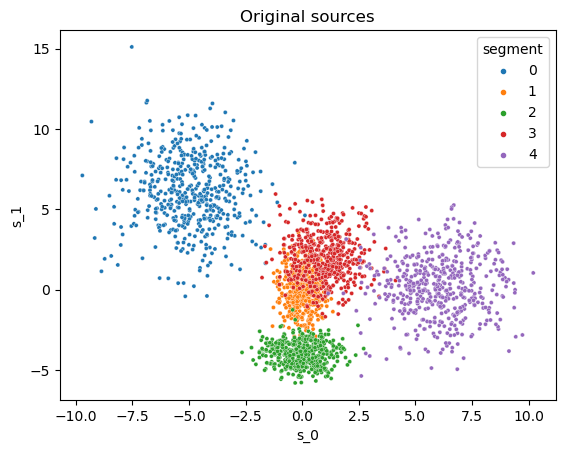

In [660]:
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10")
plt.title("Original sources")

Text(0.5, 1.0, 'Mixed sources')

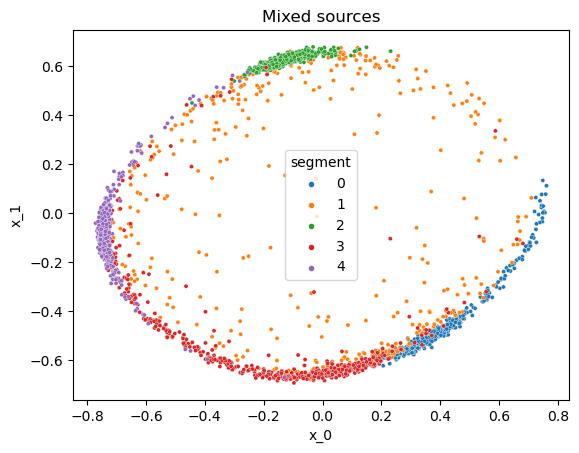

In [661]:
sns.scatterplot(data=df, x="x_0", y="x_1", hue="segment", palette="tab10")
plt.title("Mixed sources")

In [47]:
# # plot signals
# fig, axs = plt.subplots(source.shape[1], 1, figsize=(10, 5))
# for i in range(source.shape[1]):
#     axs[i].plot(source[:, i])
#     axs[i].set_title(f"Source {i}")

In [48]:
# fig, axs = plt.subplots(mixture.shape[1], 1, figsize=(10, 5))
# for i in range(mixture.shape[1]):
#     axs[i].plot(mixture[:, i])
#     axs[i].set_title(f"Mixture {i}")

## FastICA

In [662]:
ica = FastICA(n_components=dimension_of_latent_space, tol=1e-10, max_iter=10000)
fast_ica_source_predict = ica.fit_transform(mixture, method='parallel')

In [663]:
df_fast_ica = pd.concat([
  df,
  pd.DataFrame(fast_ica_source_predict, columns=[f"fast_ica_s_{i}" for i in range(fast_ica_source_predict.shape[1])]),
], axis=1)

Text(0.5, 1.0, 'Original sources')

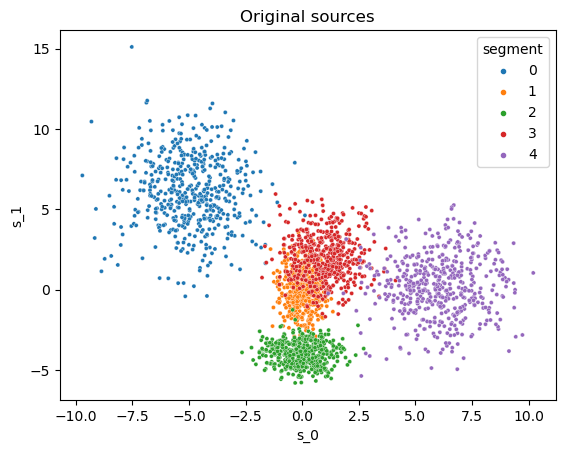

In [664]:
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10")
plt.title("Original sources")

Text(0.5, 1.0, 'Fast ICA recovered sources')

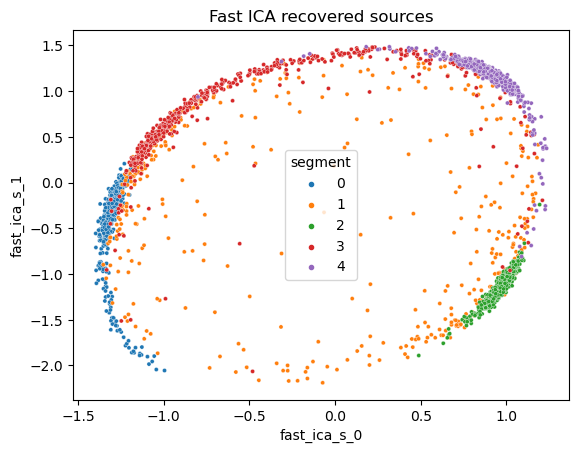

In [665]:
sns.scatterplot(data=df_fast_ica, x="fast_ica_s_0", y="fast_ica_s_1", hue="segment", palette="tab10")
plt.title("Fast ICA recovered sources")

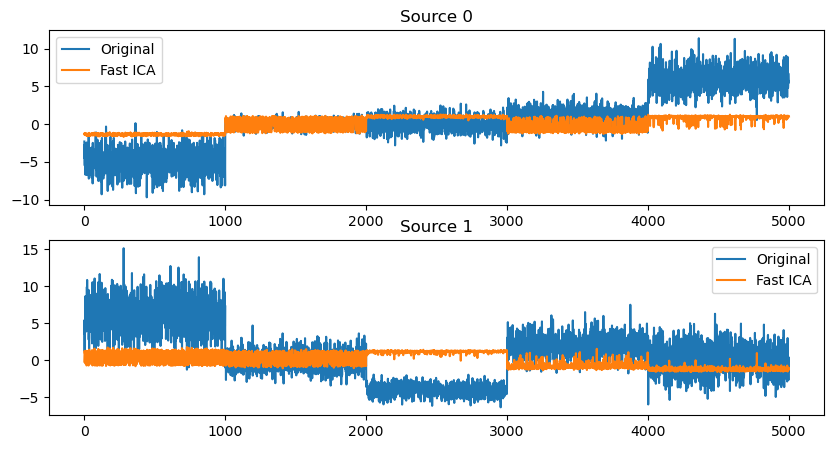

In [333]:
fig, axs = plt.subplots(source.shape[1], 1, figsize=(10, 5))
for i in range(source.shape[1]):
    axs[i].plot(source[:, i], label="Original")
    axs[i].plot(fast_ica_source_predict[:, i], label="Fast ICA")
    axs[i].set_title(f"Source {i}")
    axs[i].legend()

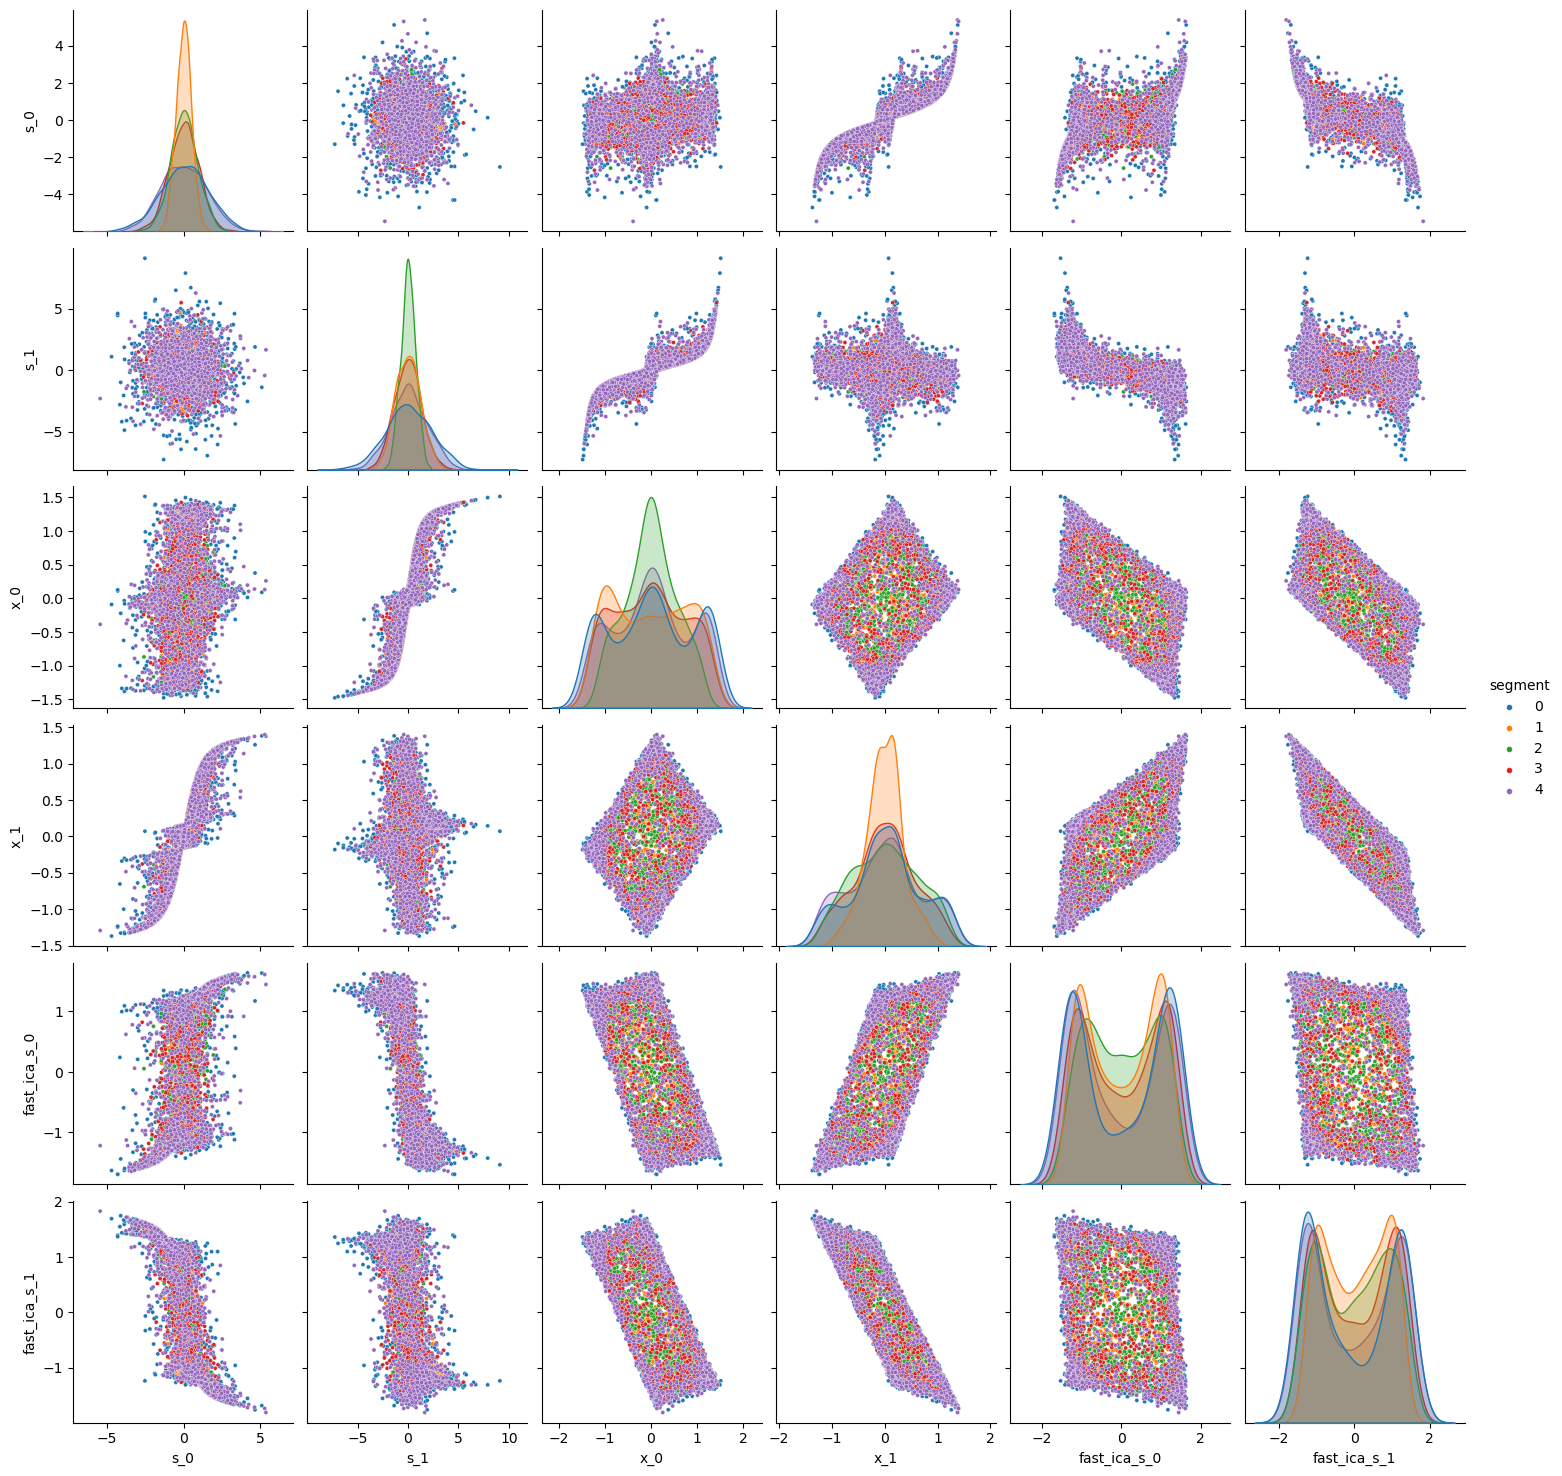

In [109]:
sns.pairplot(df_fast_ica, hue="segment", palette=f"tab10")

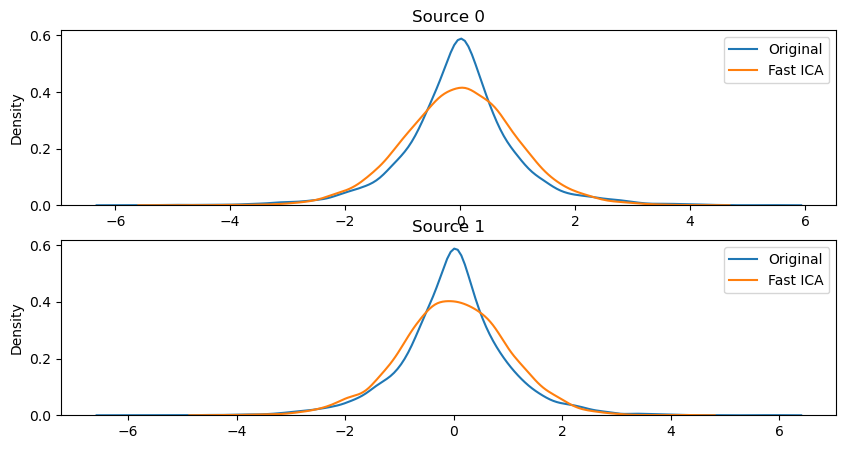

In [227]:
# plot distibution
fig, axs = plt.subplots(source.shape[1], 1, figsize=(10, 5))
for i in range(source.shape[1]):
    sns.kdeplot(source[:, i], ax=axs[i], label="Original")
    sns.kdeplot(fast_ica_source_predict[:, i], ax=axs[i], label="Fast ICA")
    axs[i].set_title(f"Source {i}")
    axs[i].legend()

In [125]:
mcc(source, fast_ica_source_predict)

0.970565942542888

## VAE

In [670]:
loader_params = (
    {"num_workers": 6, "pin_memory": True} if torch.cuda.is_available() else {}
)
data_loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    drop_last=False,
    **loader_params
)

In [671]:
d_data, d_latent, d_aux = dataset.get_dims()
vae_model = cleanVAE(
    data_dim=d_data,
    latent_dim=d_latent,
    hidden_dim=vae_hidden_dim,
    n_layers=vae_n_layers,
    activation=vae_activation,
    slope=0.1,
).to(device)

optimizer = Adam(vae_model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=0, verbose=True
)

In [672]:
vae_loss_hist, vae_perf_hist, vae_all_mccs = train(
    vae_model,
    optimizer,
    scheduler,
    data_loader,
    dataset.x,
    dataset.s,
    dataset.u,
    50,
    device,
    N=len(dataset),
    a=1000,
    b=1,
    c=0,
    d=10,
)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: -598.49 | Train Perf: 0.67 | Eval Perf: 0.67:  22%|██▏       | 11/50 [00:00<00:03, 12.34it/s]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-03.


Epoch 16/50 | Train Loss: -599.04 | Train Perf: 0.67 | Eval Perf: 0.66:  30%|███       | 15/50 [00:01<00:02, 11.78it/s]

Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00016: reducing learning rate of group 0 to 1.0000e-05.


Epoch 22/50 | Train Loss: -599.31 | Train Perf: 0.67 | Eval Perf: 0.66:  42%|████▏     | 21/50 [00:01<00:02, 12.42it/s]

Epoch 00020: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00021: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00022: reducing learning rate of group 0 to 1.0000e-08.


Epoch 50/50 | Train Loss: -599.40 | Train Perf: 0.67 | Eval Perf: 0.66: 100%|██████████| 50/50 [00:04<00:00, 12.17it/s]


Text(0.5, 1.0, 'Eval perf')

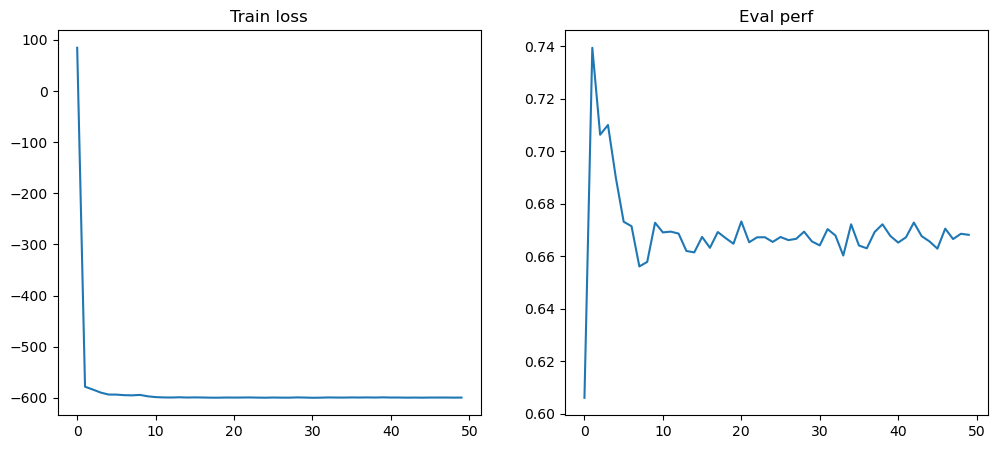

In [673]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
ax[0].plot(vae_loss_hist)
ax[0].set_title("Train loss")
ax[1].plot(vae_perf_hist)
ax[1].set_title("Eval perf")

In [674]:
vae_model.eval()
_, _, _, s_predicted, _ = vae_model(dataset.x.to(device))
s_predicted = s_predicted.cpu().detach().numpy()

In [675]:
vae_df = pd.concat([
    df,
    pd.DataFrame(s_predicted, columns=[f"vae_s_{i}" for i in range(s_predicted.shape[1])]),
], axis=1)

Text(0.5, 1.0, 'VAE recovered sources')

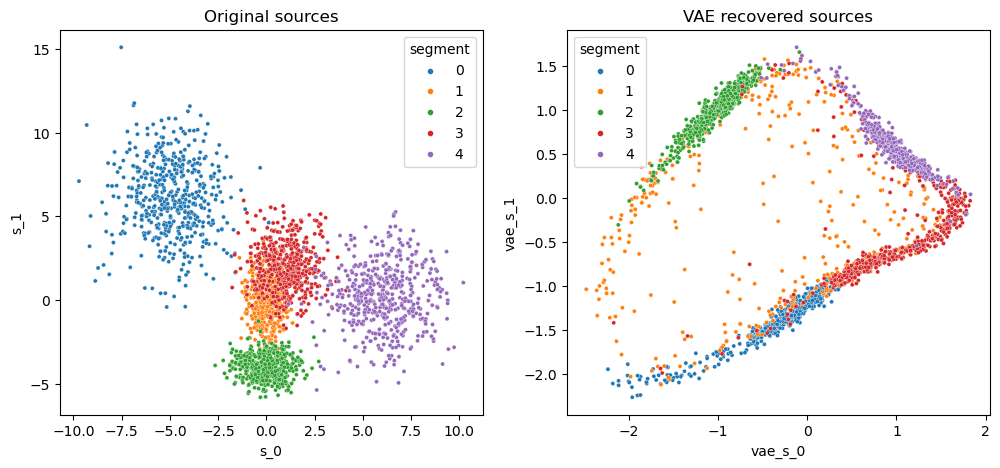

In [676]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10", ax=ax[0])
ax[0].set_title("Original sources")
sns.scatterplot(data=vae_df, x="vae_s_0", y="vae_s_1", hue="segment", palette="tab10", ax=ax[1])
ax[1].set_title("VAE recovered sources")

## IVAE

In [742]:
loader_params = (
    {"num_workers": 6, "pin_memory": True} if torch.cuda.is_available() else {}
)
data_loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    drop_last=True,
    **loader_params
)

In [743]:
ivae_model = cleanIVAE(
    data_dim=dimension_of_data_space,
    latent_dim=dimension_of_latent_space,
    hidden_dim=vae_hidden_dim,
    aux_dim=number_of_segments,
    n_layers=vae_n_layers,
    activation=vae_activation,
    slope=vae_slope,
).to(device)

optimizer = Adam(ivae_model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=0, verbose=True
)

In [744]:
ivae_loss_hist, ivae_perf_hist, ivae_all_mccs = train(
    ivae_model,
    optimizer,
    scheduler,
    data_loader,
    mixture,
    source,
    segment_labels,
    20,
    device,
    N=len(dataset),
    a=100,
    b=1,
    c=0,
    d=10,
)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 180.64 | Train Perf: 0.43 | Eval Perf: 0.36:  15%|█▌        | 3/20 [00:00<00:01,  8.58it/s]

Epoch 00002: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00003: reducing learning rate of group 0 to 1.0000e-04.


Epoch 6/20 | Train Loss: -64.20 | Train Perf: 0.40 | Eval Perf: 0.38:  25%|██▌       | 5/20 [00:00<00:01,  9.68it/s]

Epoch 00004: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00005: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00006: reducing learning rate of group 0 to 1.0000e-07.


Epoch 9/20 | Train Loss: -64.29 | Train Perf: 0.39 | Eval Perf: 0.34:  45%|████▌     | 9/20 [00:00<00:01, 10.43it/s]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-08.


Epoch 20/20 | Train Loss: -64.10 | Train Perf: 0.40 | Eval Perf: 0.35: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Text(0.5, 1.0, 'Eval perf')

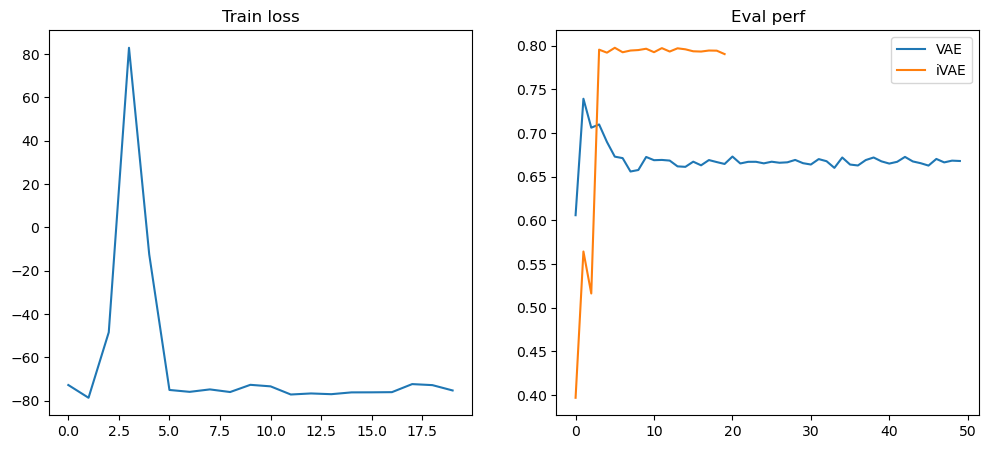

In [680]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
ax[0].plot(ivae_loss_hist)
ax[0].set_title("Train loss")
ax[1].plot(vae_perf_hist, label="VAE")
ax[1].plot(ivae_all_mccs, label="iVAE")
ax[1].legend()
ax[1].set_title("Eval perf")

In [681]:
ivae_model.eval()
_, _, _, s_predicted, _ = ivae_model(dataset.x.to(device), dataset.u.to(device))
s_predicted = s_predicted.cpu().detach().numpy()

In [682]:
ivae_df = pd.concat([
    df,
    pd.DataFrame(s_predicted, columns=[f"ivae_s_{i}" for i in range(s_predicted.shape[1])]),
], axis=1)

Text(0.5, 1.0, 'iVAE recovered sources')

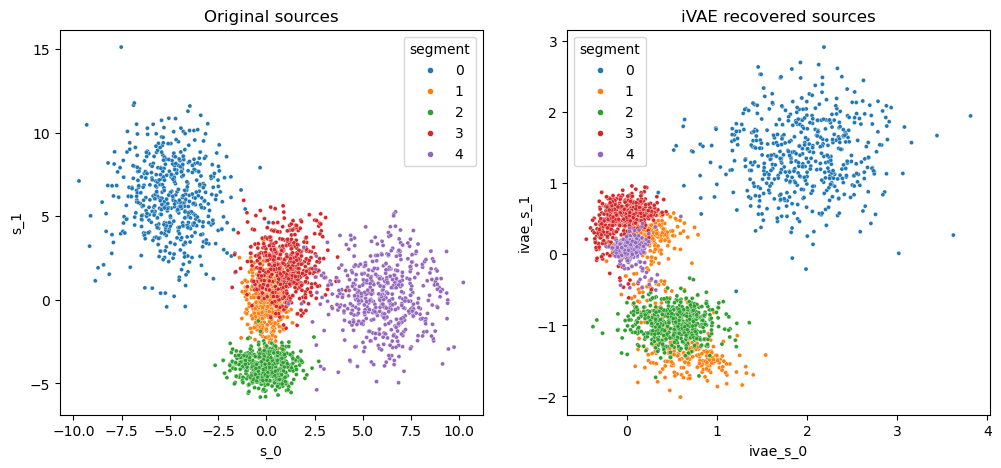

In [683]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10", ax=ax[0])
ax[0].set_title("Original sources")
sns.scatterplot(data=ivae_df, x="ivae_s_0", y="ivae_s_1", hue="segment", palette="tab10", ax=ax[1])
ax[1].set_title("iVAE recovered sources")

## Density plots

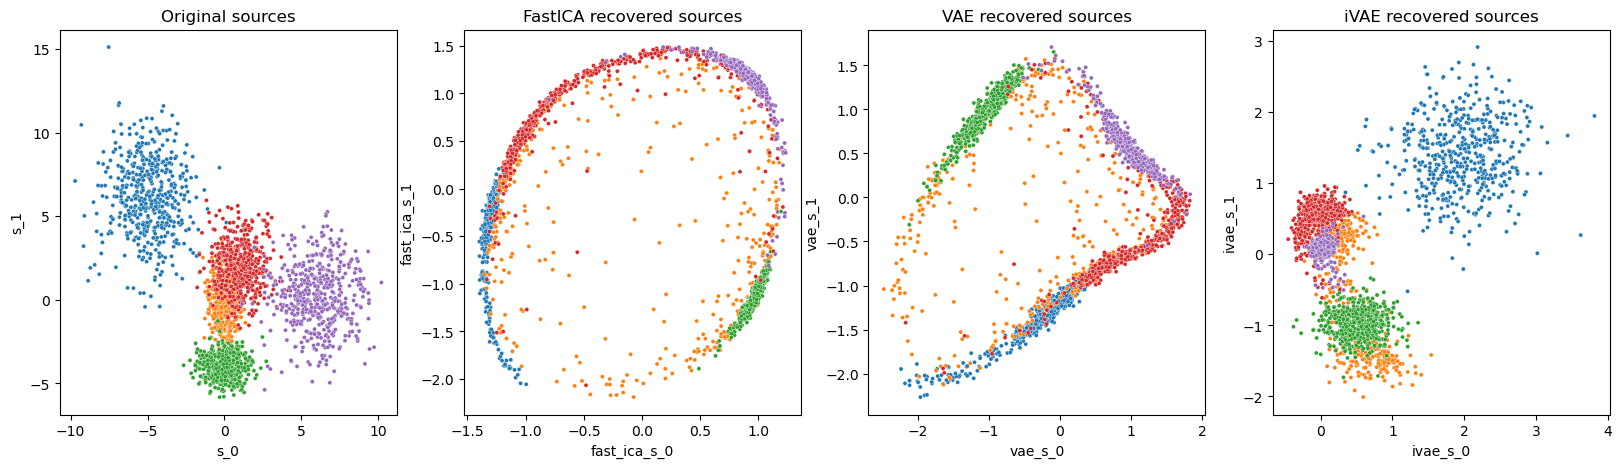

In [690]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5)) 
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10", ax=ax[0])
ax[0].set_title("Original sources")
ax[0].legend().remove()
sns.scatterplot(data=df_fast_ica, x="fast_ica_s_0", y="fast_ica_s_1", hue="segment", palette="tab10", ax=ax[1])
ax[1].set_title("FastICA recovered sources")
ax[1].legend().remove()
sns.scatterplot(data=vae_df, x="vae_s_0", y="vae_s_1", hue="segment", palette="tab10", ax=ax[2])
ax[2].set_title("VAE recovered sources")
ax[2].legend().remove()
sns.scatterplot(data=ivae_df, x="ivae_s_0", y="ivae_s_1", hue="segment", palette="tab10", ax=ax[3])
ax[3].set_title("iVAE recovered sources")
ax[3].legend().remove()

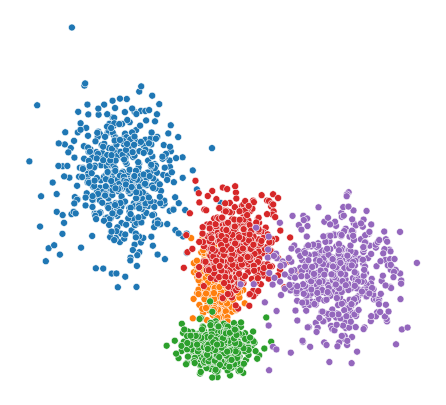

In [712]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5)) 
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10", ax=ax)
ax.legend().remove()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('original_join.pdf')

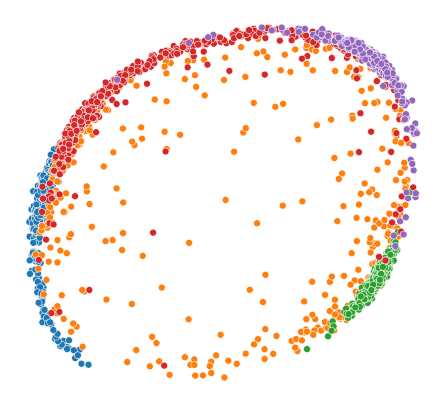

In [709]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5)) 
sns.scatterplot(data=df_fast_ica, x="fast_ica_s_0", y="fast_ica_s_1", hue="segment", palette="tab10", ax=ax)
ax.legend().remove()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('fastica_join.pdf')

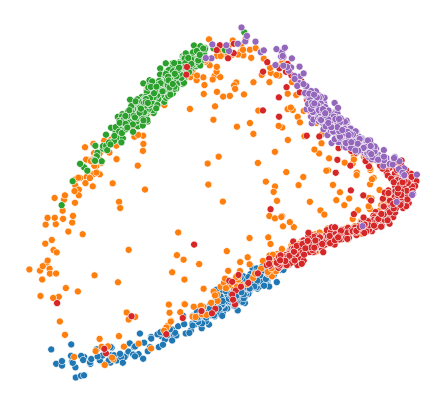

In [710]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5)) 
sns.scatterplot(data=vae_df, x="vae_s_0", y="vae_s_1", hue="segment", palette="tab10", ax=ax)
ax.legend().remove()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('vae_join.pdf')

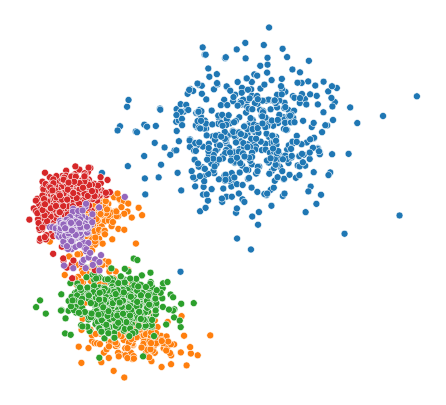

In [711]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5)) 
sns.scatterplot(data=ivae_df, x="ivae_s_0", y="ivae_s_1", hue="segment", palette="tab10", ax=ax)
ax.legend().remove()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('ivae_join.pdf')

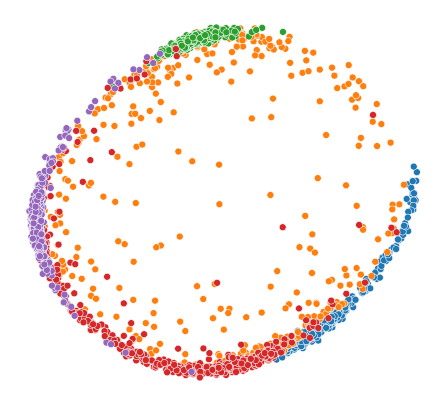

In [713]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5)) 
sns.scatterplot(data=df, x="x_0", y="x_1", hue="segment", palette="tab10", ax=ax)
ax.legend().remove()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('orinal_mixture.pdf')